### Resources
1. [Vector Quantized Variational AutoEncoder](https://github.com/priyammaz/PyTorch-Adventures/blob/main/PyTorch%20for%20Generation/AutoEncoders/Intro%20to%20AutoEncoders/Vector_Quantized_Variational_AutoEncoders.ipynb)
2. [Neural Discrete Representation Learning](https://arxiv.org/pdf/1711.00937)
3. [Estimating or propagating gradients through stochastic neurons for conditional computation](https://arxiv.org/pdf/1308.3432)


### What is a Vector Quantized Variational Autoencoder?
A Vector Quantized Variational Autoencoder (VQVAR) maps data to a discrete set of vectors. So you have an Encoder Neural Network that takes an image and compresses it down to some Latent Vector $Z$. We then compare continuous $Z$ to all our available discrete codevectors $e$ inside our codebook, and pick the codevector that is closest to our continous vector. The discrete vector is then passed to our decoder and the original image is reconstructed. We have a total of $K$ codevectors. 

![](https://substack-post-media.s3.amazonaws.com/public/images/0e37c4cc-f94a-49b0-8b5b-ca87c231ca96_1600x681.png)


We will create a module that will take a tensor, apply an "encoder" linear layer, quantize it to some embeddings, and then apply a "decoder" linear layer for our output.

Decoder Gradient: tensor([[4.]])
Decoder Gradient: tensor([ 0.0000,  0.0000, -0.8448,  0.0000])
Encoder Gradient: None


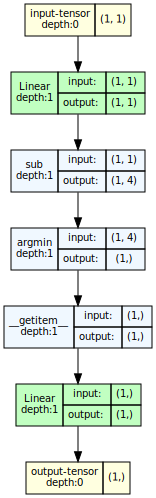

In [7]:
import torch
import torch.nn as nn

from torchview import draw_graph


class Quantize(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc = nn.Linear(1, 1)
        self.embeddings = nn.Parameter(
            torch.tensor([-10.0, 0.0, 4.0, 3.0]), requires_grad=True
        )
        self.dec = nn.Linear(1, 1)

    def forward(self, x):
        z = self.enc(x)
        closest = torch.argmin((z - self.embeddings), dim=-1)
        e_j = self.embeddings[closest]
        d = self.dec(e_j)
        return d


q = Quantize()
x = torch.ones(1).reshape(-1, 1)
out = q(x)
out.backward()
print("Decoder Gradient:", q.dec.weight.grad)
print("Decoder Gradient:", q.embeddings.grad)
print("Encoder Gradient:", q.enc.weight.grad)

model_graph = draw_graph(q, input_size=(1, 1))
model_graph.visual_graph

We can see above, that the gradient didn't make it back to $z$, which is a problem because then gradients arent making it to our encoder in that case. This happens because `argmin` is non-differentiable so PyTorch cannot compute a useful gradient through this operation.

During backpropagation, we have to find the following derivatives:
- Derivative of the Decoder w.r.t codes $\frac{\partial d}{\partial e_{\text{st}}}$
- Derivative of the codes w.r.t z $\frac{\partial e_{\text{st}}}{\partial z}$ (this is the problematic one)
- Derivative of z w.r.t the Encoder $\frac{\partial z}{\partial w_{\text{enc}}}$

This is the complete chain rule for previous model:
$$
\boxed{
\frac{\partial L}{\partial w_{\text{enc}}}
=
\frac{\partial L}{\partial d}
\cdot
\frac{\partial d}{\partial e_{\text{st}}}
\cdot
\frac{\partial e_{\text{st}}}{\partial z}
\cdot
\frac{\partial z}{\partial w_{\text{enc}}}
}
$$


$\frac{\partial L}{\partial w_{\text{enc}}}$ depends on the loss fomula used (MSE, cross-entropy, etc.) so we'll just call it:

$$
\boxed{
\frac{\partial L}{\partial d} = g_{d}
}
$$

For the next step recall that:

$$
d = w_{\text{dec}} \cdot e_{\text{st}} + b_{\text{dec}}
$$

derivative of $b_{\text{dec}}$ is 0 and derivative of $w_{\text{dec}} \cdot e_{\text{st}}$ is $w_{\text{dec}}$ so:

$$
\boxed{
\frac{\partial d}{\partial e_{\text{st}}} = w_{\text{dec}}
}
$$

$\frac{\partial e_{\text{st}}}{\partial z}$ is where everything stops because:

$$
\boxed{
\frac{\partial \text{argmin}_j |z - e_j|}{\partial z} = 0
}
$$

To build an intuition of why this is not derivable imagine to slightly change `z`, the index `j` (the argmin) stays the same most of the time. In other words the function is piecewise constant. Derivative of a constant is 0 almost everywhere, and undefined at the points where the index changes. So there’s no smooth slope for gradient descent to follow.

The proposed solution from the paper was to use a **straight through estimator** [[3]](https://arxiv.org/pdf/1308.3432), where we will copy the gradients from the input of the decoder to the output of the encoder.

To copy gradients we will do it like this:

```
e_j = z + (e_j - z).detach()
```

Why this works?

$$
e_j^{st} = \underbrace{z}_{\text{has grad}}
         + \underbrace{(e_j - z)^{\text{detach}}}_{\text{no grad}}
$$


$$
\frac{\partial e_{\text{st}}}{\partial z} = \frac{\partial z}{\partial z} + \frac{\partial (e_j - z)^{detach}}{\partial z} = 1 + 0 = 1
$$

Put it all together:

$$
\boxed{
\frac{\partial L}{\partial w_{\text{enc}}}
=
\frac{\partial L}{\partial d}
\cdot
\frac{\partial d}{\partial e_{\text{st}}}
\cdot
\frac{\partial e_{\text{st}}}{\partial z}
\cdot
\frac{\partial z}{\partial w_{\text{enc}}}

= g_{d} \cdot w_{\text{dec}} \cdot 1 \cdot w_{\text{enc}}
}
$$

Encoder Gradient: tensor([[0.6091]])


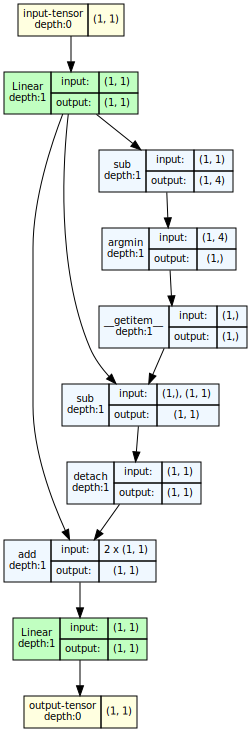

In [3]:
class Quantize(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc = nn.Linear(1, 1)
        self.embeddings = nn.Parameter(
            torch.tensor([-10.0, 0.0, 4.0, 3.0]), requires_grad=True
        )
        self.dec = nn.Linear(1, 1)

    def forward(self, x):
        z = self.enc(x)
        closest = torch.argmin((z - self.embeddings), dim=-1)
        e_j = self.embeddings[closest]
        e_j = z + (e_j - z).detach()
        d = self.dec(e_j)
        return d


q = Quantize()
x = torch.ones(1).reshape(-1, 1)
out = q(x)
out.backward()
print("Encoder Gradient:", q.enc.weight.grad)

model_graph = draw_graph(q, input_size=(1, 1))
model_graph.visual_graph

There is another optimization trick to know. There are two ways we can compute distances; goal is to compute the mean squared distance between our input $x$ and ALL codevectors $e$, so $(x-e)^2$. In the naive method, we will have to do matrix inflation to get all our shapes to line up, but this is costly. The better way is to rewrite $(x-e)^2$ as $x^2-2xe + e^2$ and just do a couple matrix multiplications to get the same output.

In [10]:
import torch
import time


class VectorQuantizer(nn.Module):
    def __init__(self, codebook_size=1024, latent_dim=2):
        super().__init__()

        self.embedding = nn.Embedding(codebook_size, latent_dim)
        self.embedding.weight.data.uniform_(-1 / codebook_size, 1 / codebook_size)

        self.latent_dim = latent_dim
        self.codebook_size = codebook_size

    def forward(self, x, efficient=True):
        batch_size = x.shape[0]

        ### Bad Implementation That Requires Matrix Expansion ###
        if not efficient:
            # C: Codebook Size, L: Latent Dim

            ### Embedding: [C, L] -> [B, C, L]
            emb = self.embedding.weight.unsqueeze(0).repeat(batch_size, 1, 1)

            ### X: [B, L] -> [B, 1, L]
            x = x.unsqueeze(1)

            ### [B, C]
            distances = torch.sum(((x - emb) ** 2), dim=-1)

        ### Alternative more Efficient Implementation ###
        else:
            ### Distance btwn every Latent and Code: (L-C)**2 = (L**2 - 2LC + C**2 ) ###

            ### L2: [B, L] -> [B, 1]
            L2 = torch.sum(x**2, dim=1, keepdim=True)

            ### C2: [C, L] -> [C]
            C2 = torch.sum(self.embedding.weight**2, dim=1).unsqueeze(0)

            ### CL: [B,L]@[L,C] -> [B, C]
            CL = x @ self.embedding.weight.t()

            ### [B, 1] - 2 * [B, C] + [C] -> [B, C]
            distances = L2 - 2 * CL + C2

        ### Grab Closest Indexes, create matrix of corresponding vectors ###
        ### Closest: [B, 1]
        closest = torch.argmin(distances, dim=-1)

        ### Create Empty Quantized Latents Embedding ###
        # latents_idx: [B, C]
        quantized_latents_idx = torch.zeros(
            batch_size, self.codebook_size, device=x.device
        )

        ### Place a 1 at the Indexes for each sample for the codebook we want ###
        batch_idx = torch.arange(batch_size)
        quantized_latents_idx[batch_idx, closest] = 1

        ### Matrix Multiplication to Grab Indexed Latents from Embeddings ###

        # quantized_latents: [B, C] @ [C, L] -> [B, L]
        quantized_latents = quantized_latents_idx @ self.embedding.weight

        return quantized_latents


def benchmark_vq(
    codebook_size=1024, latent_dim=64, batch_size=256, iters=50, device=None
):
    """Benchmark speed + peak memory of efficient vs inefficient quantization in a single function."""

    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    print(f"\n--- Benchmark (device={device}) ---")
    print(f"Batch={batch_size}, Codebook={codebook_size}, Latent={latent_dim}")

    vq = VectorQuantizer(codebook_size=codebook_size, latent_dim=latent_dim).to(device)
    x = torch.randn(batch_size, latent_dim, device=device)

    # Warmup
    with torch.no_grad():
        vq(x, efficient=False)
        vq(x, efficient=True)

    def measure(fn):
        if device == "cuda":
            torch.cuda.empty_cache()
            torch.cuda.reset_peak_memory_stats()

        start = time.time()
        with torch.no_grad():
            for _ in range(iters):
                fn()
        end = time.time()

        t = (end - start) / iters
        mem = torch.cuda.max_memory_allocated() if device == "cuda" else None
        return t, mem

    # Inefficient
    t_slow, mem_slow = measure(lambda: vq(x, efficient=False))

    # Efficient
    t_fast, mem_fast = measure(lambda: vq(x, efficient=True))

    # Print results
    def fmt(m):
        return f"{m / (1024**2):.2f} MB" if m is not None else "N/A (CPU)"

    print(f"\nInefficient (repeat expand):")
    print(f"  time   : {t_slow * 1000:.3f} ms/iter")
    print(f"  memory : {fmt(mem_slow)}")

    print(f"\nEfficient (no expand):")
    print(f"  time   : {t_fast * 1000:.3f} ms/iter")
    print(f"  memory : {fmt(mem_fast)}")

    if mem_slow and mem_fast:
        print(f"\nMemory ratio (ineff/eff): {mem_slow / mem_fast:.2f}x")
    print(f"Speedup (ineff/eff): {t_slow / t_fast:.2f}x")


benchmark_vq(codebook_size=1024, latent_dim=64, batch_size=64)
benchmark_vq(codebook_size=1024, latent_dim=64, batch_size=512)
benchmark_vq(codebook_size=4096, latent_dim=64, batch_size=512)


--- Benchmark (device=cuda) ---
Batch=64, Codebook=1024, Latent=64

Inefficient (repeat expand):
  time   : 0.422 ms/iter
  memory : 56.39 MB

Efficient (no expand):
  time   : 0.290 ms/iter
  memory : 9.17 MB

Memory ratio (ineff/eff): 6.15x
Speedup (ineff/eff): 1.45x

--- Benchmark (device=cuda) ---
Batch=512, Codebook=1024, Latent=64

Inefficient (repeat expand):
  time   : 4.072 ms/iter
  memory : 392.50 MB

Efficient (no expand):
  time   : 0.353 ms/iter
  memory : 14.64 MB

Memory ratio (ineff/eff): 26.81x
Speedup (ineff/eff): 11.55x

--- Benchmark (device=cuda) ---
Batch=512, Codebook=4096, Latent=64

Inefficient (repeat expand):
  time   : 15.308 ms/iter
  memory : 1545.25 MB

Efficient (no expand):
  time   : 0.478 ms/iter
  memory : 33.40 MB

Memory ratio (ineff/eff): 46.26x
Speedup (ineff/eff): 32.06x


In an ordinary autoencoder, the mean-squared error (MSE) between the input and its reconstruction is
sufficient to train all components end-to-end.

However, once we introduce a **discrete bottleneck**, as in the VQ-VAE, this assumption breaks.
The encoder output \( z_e(x) \) is no longer fed directly to the decoder. Instead, it is replaced by the
nearest codebook vector:

$$
z_q(x) = e_k, \quad k = \arg\min_j \| z_e(x) - e_j \|^2.
$$

This nearest-neighbor quantization is **not differentiable**. During backpropagation, the gradient of the
reconstruction loss has no path into the codebook entries \( e_k \). The VQ-VAE paper states:

> “Due to the straight-through gradient estimation … the embeddings \( e_i \) receive **no gradients from the
reconstruction loss**.”  

This means that if we used only MSE, the decoder would learn, the encoder would learn (via a special
trick described below), **but the quantizer—the codebook—would learn nothing at all**. The codebook
would remain essentially random, and the model would not converge.

This is the central challenge of discrete latent learning:  
**the reconstruction loss cannot update the discrete codes.**

---


To address this, the VQ-VAE introduces a composite objective consisting of three terms:

$$
\mathcal{L} = 
\underbrace{\log p(x \mid z_q(x))}_{\text{reconstruction}} +
\underbrace{\| \text{sg}[z_e(x)] - e_k \|^2}_{\text{codebook loss}} +
\beta \underbrace{\| z_e(x) - \text{sg}[e_k] \|^2}_{\text{commitment loss}}.
$$

Here, **sg** denotes the stop-gradient operator. Each term is responsible for training a different part of
the model. The paper explains this division of labor:

> “The decoder optimizes the first loss term only, the encoder optimizes the first and the last loss terms,
and the embeddings are optimized by the middle loss term.”  


Let’s break these down.

---

**Reconstruction Loss** — Trains Encoder + Decoder. Even though the decoder receives a discrete latent $\( z_q \)$, the encoder receives gradients through the
**straight-through estimator**, which treats the quantization step as if it were the identity during backprop.

As the paper says:

> “During the backward pass the gradient \( \nabla_z L \) is passed unaltered to the encoder.”  

Thus, the encoder learns how its continuous outputs should move to reduce reconstruction error as if no quantization had taken place.

But critically, **the codebook still receives no gradient from this term**.

---

**Codebook Loss** — Trains the Embedding Vectors

To update the quantizer, the authors add a second loss term:

$$
\| \text{sg}[z_e(x)] - e_k \|^2.
$$

This uses the encoder output as a fixed target (thanks to stop-gradient) and updates only the embedding
vectors. The paper describes this as:

> “One of the simplest dictionary learning algorithms, Vector Quantisation (VQ).”  

This behaves like **online k-means**, pulling each embedding vector toward the encoder outputs that
select it.

Without this term, **the codebook would never move**, and the model would collapse.

---

**Commitment Loss** — Stabilizes the Encoder

The commitment loss:

$$
\beta \| z_e(x) - \text{sg}[e_k] \|^2
$$

encourages the encoder to stay close to the embeddings it chooses, preventing its outputs from drifting
arbitrarily. Without this term, the codebook might move too slowly while the encoder keeps changing,
destabilizing training.

The authors explain:

> “To make sure the encoder commits to an embedding … we add a commitment loss.”  

---

With the three-term loss:

- The **decoder** learns from reconstruction loss only.
- The **encoder** learns from reconstruction + commitment losses.
- The **codebook** learns from the VQ loss only.

This decoupling is essential because each component has a different role and receives gradients
through different mechanisms. The reconstruction loss cannot update the codebook, so VQ-VAE
introduces additional losses to ensure all parts of the model learn harmoniously.

This design is what makes VQ-VAE the first discrete latent model to match the performance of
continuous VAEs while offering the advantages of discrete representations.

### Gradient Flow in VQ-VAE: How Encoder, Decoder, and Codebook Receive Gradients  
(Using Chain Rule + Straight-Through Estimator)

We analyze how gradients are computed for the **decoder**, **encoder**, and **codebook** in a
VQ-VAE. The total loss is:

$$
\mathcal{L} =
\underbrace{\mathcal{L}_{\text{rec}}}_{\log p(x|z_q)}
+
\underbrace{\| \text{sg}[z_e] - e_k \|^2}_{\mathcal{L}_{\text{vq}}}
+
\beta \underbrace{\| z_e - \text{sg}[e_k] \|^2}_{\mathcal{L}_{\text{commit}}}
$$

where:

- $z_e = \text{enc}(x; \theta_e)$  
- $z_q$ is the quantized latent  
- $e_k$ is the selected codebook embedding  
- $\text{sg}[\cdot]$ is the stop-gradient operator (identity forward, 0 in backward)

The straight-through estimator (STE) defines:

$$
z_q = z_e + \text{sg}[e_k - z_e]
$$

Forward: $z_q = e_k$  
Backward: $\frac{\partial z_q}{\partial z_e} = I,\quad \frac{\partial z_q}{\partial e_k} = 0$

---

Decoder Gradients $(\theta_d)$

The decoder only appears in the reconstruction term $\mathcal{L}_{\text{rec}}$:

$$
\hat{x} = \text{dec}(z_q; \theta_d), \qquad
\mathcal{L}_{\text{rec}} = \|x - \hat{x}\|^2.
$$

By chain rule:

$$
\frac{\partial \mathcal{L}}{\partial \theta_d}
= 
\frac{\partial \mathcal{L}_{\text{rec}}}{\partial \hat{x}}
\cdot
\frac{\partial \hat{x}}{\partial \theta_d}.
$$

No gradients come from $\mathcal{L}_{\text{vq}}$ or $\mathcal{L}_{\text{commit}}$.

---

2. Encoder Gradients $(\theta_e)$

The encoder appears in:

1. $z_e = \text{enc}(x;\theta_e)$  
2. the reconstruction path via $z_q$ and STE  
3. the commitment loss

---

Flow:

$$
\theta_e \rightarrow z_e \rightarrow z_q \rightarrow \hat{x} \rightarrow \mathcal{L}_{\text{rec}}
$$

Chain rule:

$$
\frac{\partial \mathcal{L}_{\text{rec}}}{\partial \theta_e}
=
\frac{\partial \mathcal{L}_{\text{rec}}}{\partial \hat{x}}
\cdot
\frac{\partial \hat{x}}{\partial z_q}
\cdot
\frac{\partial z_q}{\partial z_e}
\cdot
\frac{\partial z_e}{\partial \theta_e}.
$$

Using STE:

$$
\frac{\partial z_q}{\partial z_e} = I,
$$

so:

$$
\frac{\partial \mathcal{L}_{\text{rec}}}{\partial \theta_e}
=
\frac{\partial \mathcal{L}_{\text{rec}}}{\partial \hat{x}}
\cdot
\frac{\partial \hat{x}}{\partial z_q}
\cdot
\frac{\partial z_e}{\partial \theta_e}.
$$

**Interpretation:** The encoder receives the same gradient as if quantization did not happen.

---

Commitment term:

$$
\mathcal{L}_{\text{commit}} = 
\beta \| z_e - \text{sg}[e_k] \|^2.
$$

Gradient wrt encoder output:

$$
\frac{\partial \mathcal{L}_{\text{commit}}}{\partial z_e}
= 2\beta (z_e - e_k).
$$

Thus:

$$
\frac{\partial \mathcal{L}_{\text{commit}}}{\partial \theta_e}
=
2\beta (z_e - e_k)
\cdot
\frac{\partial z_e}{\partial \theta_e}.
$$

---

Total Encoder Gradient

$$
\frac{\partial \mathcal{L}}{\partial \theta_e}
=
\underbrace{
\frac{\partial \mathcal{L}_{\text{rec}}}{\partial \hat{x}}
\cdot
\frac{\partial \hat{x}}{\partial z_q}
\cdot
\frac{\partial z_e}{\partial \theta_e}
}_{\text{from reconstruction}}
+
\underbrace{
2\beta (z_e - e_k)
\cdot \frac{\partial z_e}{\partial \theta_e}
}_{\text{from commitment}}.
$$

---

Codebook Gradients $(e_k)$

The codebook appears in:

- $z_q$ (forward), but receives **no gradient** from $\mathcal{L}_{\text{rec}}$ due to STE  
- $\mathcal{L}_{\text{vq}} = \| \text{sg}[z_e] - e_k \|^2$  
- $\mathcal{L}_{\text{commit}}$ but with $\text{sg}[e_k]$ (blocked)

Thus the **only gradient for $e_k$** comes from the VQ loss:

$$
\mathcal{L}_{\text{vq}} = \| \text{sg}[z_e] - e_k \|^2.
$$

Since $\text{sg}[z_e]$ is constant during backward:

$$
\frac{\partial \mathcal{L}}{\partial e_k}
=
\frac{\partial \mathcal{L}_{\text{vq}}}{\partial e_k}
=
2 (e_k - z_e).
$$

This is exactly an online **k-means / vector quantization update**.

---

Summary

| Component | Learns From | Gradient Expression |
|----------|-------------|---------------------|
| **Decoder** $(\theta_d)$ | Reconstruction loss | $$\frac{\partial \mathcal{L}}{\partial \theta_d} = \frac{\partial \mathcal{L}_{\text{rec}}}{\partial \theta_d}$$ |
| **Encoder** $(\theta_e)$ | Reconstruction + Commitment | $$\frac{\partial \mathcal{L}}{\partial \theta_e} = \frac{\partial \mathcal{L}_{\text{rec}}}{\partial \theta_e} + 2\beta(z_e - e_k)\frac{\partial z_e}{\partial \theta_e}$$ |
| **Codebook** $(e_k)$ | VQ Loss Only | $$\frac{\partial \mathcal{L}}{\partial e_k} = 2 (e_k - z_e)$$ |

This demonstrates the essential point:

- **MSE does *not* update the codebook**
- The **encoder** learns through STE and commitment
- The **decoder** learns normally
- The **codebook** learns via its own VQ objective

If you'd like, I can also produce a **fully annotated diagram**, a **PyTorch backward simulation**, or a **toy numerical example** that prints actual gradients.



<img src="https://upload.wikimedia.org/wikipedia/commons/b/bd/Convolutional_neural_network%2C_convolution_worked_example.png" width="800">


In this notebook I explore how different architectural choices in a fully convolutional Vector-Quantised Variational Autoencoder (VQ-VAE) influence the quality of audio reconstruction.

Evaluating reconstruction quality remains the most direct and fundamental way to understand how well the model learns a latent representation. In the case of a VQ-VAE, however, the reconstruction loss is only one part of the full objective. Because the latent space is discrete, the encoder output must be mapped to the nearest embedding vector in a learned codebook. This introduces two additional terms—the codebook loss and the commitment loss—that encourage the embeddings to represent the encoder outputs faithfully and prevent the encoder from drifting too far from the discrete latent space.

$$
\mathcal{L} = 
\underbrace{\|x - \hat{x}\|_2^2}_{\text{reconstruction}} 
\;+\;
\underbrace{\|\mathrm{sg}[z_e] - e\|_2^2}_{\text{codebook loss}} 
\;+\;
\beta \,
\underbrace{\|z_e - \mathrm{sg}[e]\|_2^2}_{\text{commitment loss}}
$$


The central question is how reconstruction fidelity changes as I vary the main architectural parameters of the VQ-VAE. As in the earlier autoencoder experiment, I investigate two fundamental dimensions:

- **number of layers** (`n_layers`): determines the depth of the encoder and decoder, and thus the compression factor. More layers produce a more aggressive temporal downsampling and force the discrete latent space to model longer-range structure.
- **hidden dimension** (`hidden_dim`): the number of channels in every convolutional block. A larger hidden dimension increases the capacity of both the encoder and the decoder and typically improves quantisation quality by giving the encoder a richer continuous representation before quantisation.
- **number of codebook** entries (`num_codes` or $K$): the size of the discrete latent space. This determines how many distinct embedding vectors the encoder can choose from when mapping its continuous output to the discrete representation.

In [1]:
import torch
import torchaudio
import torch.optim as optim
import torch.nn.functional as F

from vqvae import VQVAE
from datasets import load_dataset

filename = "M01UD01p10"
x, sr = torchaudio.load(f"data/audio/{filename}.wav")

from IPython.display import Audio
Audio(x.detach().squeeze().cpu().numpy(), rate=16000)

In [ ]:
T = x.shape[-1]
import soundfile as sf

T_pad = ((T + 63) // 64) * 64
if T_pad != T:
    x = F.pad(x, (0, T_pad - T))  # [1, 1, T_pad]

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

plt.ion()  # interactive mode on
fig, ax = plt.subplots(figsize=(5, 5))

def plot_codebook(embeddings, step):
    """
    embeddings: tensor [codebook_size, D]
    step: int
    save: whether to also save a PNG on disk
    """
    emb = embeddings.detach().cpu().numpy()
    _, D = emb.shape

    if D > 2:
        emb_2d = PCA(n_components=2).fit_transform(emb)
    else:
        emb_2d = emb

    ax.clear()
    ax.scatter(emb_2d[:, 0], emb_2d[:, 1], s=12, alpha=0.7)
    ax.set_title(f"Codebook Embeddings at Step {step}")
    ax.set_xlabel("dim 1")
    ax.set_ylabel("dim 2")
    ax.grid(True)

    # update live figure
    fig.canvas.draw()
    plt.pause(0.01)

device = "cuda" if torch.cuda.is_available() else "cpu"
x = x.unsqueeze(1).to(device)
n_layers = 6
hidden_dim=256
codebook_size=10
model = VQVAE(hidden_dim=hidden_dim, n_layers=n_layers, codebook_size=codebook_size).to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.0005)
vq_scale = 0.0001   # or start even smaller like 0.01
for step in range(10000):
    optimizer.zero_grad()
    y, z_e, ids = model(x)
    e_k = model.vq.codebook(ids)  # [B*T_e, D]
    mse = F.mse_loss(y, x)
    codebook_loss = torch.mean((z_e.detach() - e_k) ** 2)
    commitment_loss = torch.mean((z_e - e_k.detach()) ** 2)
    beta = 0.25
    

    loss = mse + vq_scale * codebook_loss + vq_scale * beta * commitment_loss

    
    loss.backward()
    optimizer.step()
    if step == 400:
        print(f"step {step}: loss = {loss.item():.6f}")
        print(f"mse: {mse.item():.4f}, cb: {codebook_loss.item():.4f}, com: {commitment_loss.item():.4f}")
        vq_scale = 1

    if step % 100 == 0:
        print(model.vq.codebook.weight[0][:10])
        x_np = x[0,0].detach().cpu().numpy()
        y_np = y[0,0].detach().cpu().numpy()
        # sf.write(f"recon_step_{step}.wav", y_np, samplerate=16000)
        print(set(ids.tolist()))
        print(f"step {step}: loss = {loss.item():.6f}")
        print(f"mse: {mse.item():.4f}, cb: {codebook_loss.item():.4f}, com: {commitment_loss.item():.4f}")

        # 🔥 plot codebook embeddings
        # plot_codebook(model.vq.codebook.weight, step)

print(f"step {step+1}: loss = {loss.item():.6f}")

tensor([-0.4053,  0.4491, -1.2013, -0.1683, -0.5358, -0.1565,  0.3538, -0.2255,
        -0.7550, -2.8287], device='cuda:0', grad_fn=<SliceBackward0>)
{6}
step 0: loss = 0.130997
mse: 0.1309, cb: 0.8716, com: 0.8716
tensor([-0.4051,  0.4488, -1.2007, -0.1682, -0.5355, -0.1564,  0.3536, -0.2254,
        -0.7546, -2.8273], device='cuda:0', grad_fn=<SliceBackward0>)
{6}
step 100: loss = 0.002919
mse: 0.0028, cb: 0.7934, com: 0.7934
tensor([-0.4025,  0.4614, -1.1924, -0.1585, -0.5323, -0.1435,  0.3584, -0.2194,
        -0.7504, -2.8174], device='cuda:0', grad_fn=<SliceBackward0>)
{0, 1, 3, 4, 6, 7}
step 200: loss = 0.009052
mse: 0.0017, cb: 59.1303, com: 59.1303
tensor([-0.3519,  0.5519, -1.1210, -0.1138, -0.4740, -0.0255,  0.4449, -0.1360,
        -0.6827, -2.7209], device='cuda:0', grad_fn=<SliceBackward0>)
{0, 1, 2, 3, 4, 5, 6, 9}
step 300: loss = 0.023054
mse: 0.0013, cb: 174.4196, com: 174.4196
step 400: loss = 0.035682
mse: 0.0011, cb: 276.8137, com: 276.8137
tensor([-0.3110,  0.5892,

In [ ]:
from IPython.display import Audio

model.enc.verbose = True
model.dec.verbose = True
with torch.no_grad():
    y, _, _ = model(x.to(device))

# torchaudio.save(f"data/results/{filename}-{n_layers}layers{hidden_dim}hiddendim.wav", y.squeeze().cpu().unsqueeze(0), sample_rate=16000)
Audio(y.detach().squeeze().cpu().numpy(), rate=16000)

Input: torch.Size([1, 1, 122624])
Encoder
After layer 1: torch.Size([1, 256, 61312])
After layer 2: torch.Size([1, 256, 30656])
After layer 3: torch.Size([1, 256, 15328])
After layer 4: torch.Size([1, 256, 7664])
After layer 5: torch.Size([1, 256, 3832])
After layer 6: torch.Size([1, 256, 1916])
Decoder
After layer 1: torch.Size([1, 256, 3832])
After layer 2: torch.Size([1, 256, 7664])
After layer 3: torch.Size([1, 256, 15328])
After layer 4: torch.Size([1, 256, 30656])
After layer 5: torch.Size([1, 256, 61312])
Output: torch.Size([1, 1, 122624])


In [2]:
import torchaudio
import matplotlib.pyplot as plt
import math
import torch.nn.functional as F

from vqvae import VQVAE

def pad_to_64(x):
    print(x.shape)
    _, _, T = x.shape
    T_pad = math.ceil(T / 64) * 64
    pad_right = T_pad - T
    x_padded = F.pad(x, (0, pad_right))
    return x_padded, T

x, sr = torchaudio.load("../../data/audio/M01UD01p10.wav")
x, _ = pad_to_64(x.unsqueeze(1))
print(x.shape)


model = VQVAE(hidden_dim=64, codebook_size=512)
y, z_e_flat, z_q, ids = model(x)

y.shape

RuntimeError: Failed to create AudioDecoder for ../../data/audio/M01UD01p10.wav: Could not open input file: ../../data/audio/M01UD01p10.wav No such file or directory

In [ ]:
from datasets import load_dataset

ds = load_dataset("audiofolder", data_dir="/home/lpozzi/Git/bitbybit/data/audio")  # {"train": Dataset}

def collate_fn(batch):
    wavs = [torch.tensor(b["audio"]["array"]).float() for b in batch]
    lengths = torch.tensor([w.shape[-1] for w in wavs])          # [B]
    max_len = lengths.max()

    padded = []
    for w in wavs:
        pad = max_len - w.shape[-1]
        padded.append(F.pad(w.unsqueeze(0), (0, pad)))  # [1, max_len]

    x = torch.stack(padded, dim=0)      # [B, 1, max_len]
    return x, lengths

from torch.utils.data import DataLoader

trainloader = DataLoader(
    ds['train'],
    batch_size=2,
    shuffle=True,
    collate_fn=collate_fn,
)

In [1]:
import torch 
device = "cuda" if torch.cuda.is_available() else "cpu"
device

/home/lpozzi/Git/bitbybit/.venv/lib/python3.11/site-packages/torch/cuda/__init__.py:182: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:119.)
  return torch._C._cuda_getDeviceCount() > 0


'cpu'

In [ ]:
from vqvae import VQVAE, Encoder, Decoder
from datasets import load_dataset
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


class AE(nn.Module):
    def __init__(self, hidden_dim=64):
        super().__init__()
        n=6
        self.enc = Encoder(in_channels=1, hidden_dim=hidden_dim, n_layers=n)
        self.dec = Decoder(out_channels=1, hidden_dim=hidden_dim, n_layers=n)

    def forward(self, x):
        z = self.enc(x)      # [B, D, T_e]
        y = self.dec(z)      # [B, 1, T]
        return y

# ---- Load ONE audio ----
ds = load_dataset("audiofolder", data_dir="/home/lpozzi/Git/bitbybit/data/audio")
sample = ds["train"][-9]["audio"]["array"]   # first audio only

x = torch.tensor(sample, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # [1, 1, T]

# make length multiple of 64 (for Encoder/Decoder stride)
T = x.shape[-1]
T_pad = ((T + 63) // 64) * 64
if T_pad != T:
    x = F.pad(x, (0, T_pad - T))  # [1, 1, T_pad]

device = "cuda" if torch.cuda.is_available() else "cpu"
x = x.to(device)

# ---- Model & optimizer ----
model = AE(hidden_dim=1024).to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.0005)

# ---- Training on the single audio ----
for step in range(500):
    y = model(x)
    loss = F.mse_loss(y, x)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if step % 100 == 0:
        print(f"step {step}: loss = {loss.item():.6f}")


step 0: loss = 0.029989
step 100: loss = 0.002819
step 200: loss = 0.000687
step 300: loss = 0.000312
step 400: loss = 0.000169


In [ ]:
https://huggingface.co/datasets/MushanW/GLOBE

In [ ]:
# import torchaudio
# import math
# def pad_to_64(x):
#     print(x.shape)
#     _, _, T = x.shape
#     T_pad = math.ceil(T / 64) * 64
#     pad_right = T_pad - T
#     x_padded = F.pad(x, (0, pad_right))
#     return x_padded, T

# x, sr = torchaudio.load("../../data/audio/M01UD01p10.wav")
# x, _ = pad_to_64(x.unsqueeze(1))

torch.Size([1, 1, 122596])


In [2]:
from IPython.display import Audio
Audio(x.detach().squeeze().cpu().numpy(), rate=16000)

In [2]:
from IPython.display import Audio

with torch.no_grad():
    y = model(x.to(device))

Audio(y.detach().squeeze().cpu().numpy(), rate=16000)

In [2]:
from IPython.display import Audio

with torch.no_grad():
    y = model(x.to(device))

Audio(y.detach().squeeze().cpu().numpy(), rate=16000)

In [5]:
y

tensor([[[-0.1394, -0.0013, -0.0141,  ...,  0.0040, -0.0199, -0.1444]]],
       device='cuda:0')

The VQ-VAE learns a discrete codebook and encoder/decoder first.
→ Then a separate autoregressive model is trained to predict the sequence (or grid) of discrete codes.
→ This autoregressive model is what they refer to as “the prior.”